In [1]:
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [10]:
import argparse
import logging

# TODO: ADD TO CONTAINER
from pathlib import Path

from spatialdata import read_zarr

In [2]:
# noqa: E402

import datetime

date_var = datetime.datetime.now().strftime("%Y%m%d")

In [3]:
# noqa: E402

import spatialdata as sd

/home/ubuntu/miniforge3/envs/cellseg_benchmark/lib/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/home/ubuntu/miniforge3/envs/cellseg_benchmark/lib/python3.12/site-packages/xarray_schema/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


In [4]:
# noqa: E402

import sys

sys.path.insert(1, "/dss/dssfs03/pn52re/pn52re-dss-0001/cellseg-benchmark")

In [5]:
# noqa: E402

import geopandas as gpd
from spatialdata.models import PointsModel


def count_assigned_transcripts(
    sdata, sdata_transcripts_key, boundaries_to_process=None
):
    """Calculate transcript assignment to cells across boundaries, handling 3D z-planes."""
    # Load transcripts
    transcripts_df = PointsModel.parse(
        sdata[sdata_transcripts_key], sort=True
    ).compute()[["x", "y", "gene", "transcript_id", "global_z"]]
    transcripts_gdf = gpd.GeoDataFrame(
        transcripts_df, geometry=gpd.points_from_xy(transcripts_df.x, transcripts_df.y)
    )
    print(f"Loaded {len(transcripts_gdf)} transcripts")

    # Filter boundaries
    available_boundaries = {
        k: v for k, v in sdata.shapes.items() if k.startswith("boundaries_")
    }
    if boundaries_to_process:
        boundary_keys = [
            name if name.startswith("boundaries_") else f"boundaries_{name}"
            for name in boundaries_to_process
        ]
        available_boundaries = {
            k: v for k, v in available_boundaries.items() if k in boundary_keys
        }

    results = {}

    for boundaries_name, boundaries in available_boundaries.items():
        dataset_name = boundaries_name.replace("boundaries_", "")
        print(f"Processing {dataset_name}")

        if (
            boundaries is None
            or boundaries.empty
            or "geometry" not in boundaries.columns
        ):
            print("  Skipping - invalid geometry")
            continue

        try:
            if "ZIndex" not in boundaries.columns:
                # 2D case
                assigned, total = _process_boundaries(boundaries, transcripts_gdf)
                dimension = "2d"
            else:
                unique_z = boundaries["ZIndex"].unique()
                if len(unique_z) == 1:
                    # Single z-plane
                    z_boundaries = boundaries[boundaries["ZIndex"] == unique_z[0]]
                    z_transcripts = transcripts_gdf[
                        transcripts_gdf["global_z"] == unique_z[0]
                    ]
                    assigned, total = _process_boundaries(z_boundaries, z_transcripts)
                    dimension = "2d"
                else:
                    # Multiple z-planes
                    print(f"  Processing {len(unique_z)} z-planes")
                    total_assigned, total_transcripts = 0, 0

                    for z_index in sorted(unique_z):
                        z_boundaries = boundaries[boundaries["ZIndex"] == z_index]
                        z_transcripts = transcripts_gdf[
                            transcripts_gdf["global_z"] == z_index
                        ]

                        z_assigned, z_total = _process_boundaries(
                            z_boundaries, z_transcripts
                        )
                        total_assigned += z_assigned
                        total_transcripts += z_total

                    assigned, total = total_assigned, total_transcripts
                    dimension = "3d"

            results[dataset_name] = {
                "assigned_count": assigned,
                "unassigned_count": total - assigned,
                "total_count": total,
                "pct_assigned": round((assigned / total) * 100, 2) if total > 0 else 0,
                "dimension": dimension,
            }
            print(
                f"  {assigned}/{total} assigned ({results[dataset_name]['pct_assigned']}%) - {dimension}"
            )

        except Exception as e:
            print(f"  Error: {e}")

    return results


def _process_boundaries(boundaries_gdf, transcripts_subset):
    """Helper to process boundaries and return assigned count."""
    if boundaries_gdf.empty or transcripts_subset.empty:
        return 0, len(transcripts_subset)

    boundaries_unified = gpd.GeoDataFrame(
        geometry=[boundaries_gdf["geometry"].union_all(method="unary")]
    )
    joined = gpd.sjoin(
        transcripts_subset, boundaries_unified, how="left", predicate="within"
    )
    assigned = joined["index_right"].notna().sum()
    return assigned, len(transcripts_subset)

In [6]:
data_dir = os.path.abspath("/home/ubuntu/gitrepos/cellseg-benchmark/data")
!ls -l $data_dir

lrwxrwxrwx 1 ra98gaq pn52ra 53 Aug  1 17:38 /home/ubuntu/gitrepos/cellseg-benchmark/data -> /dss/dssfs03/pn52re/pn52re-dss-0001/cellseg-benchmark


In [7]:
sample_name = "foxf2_s4_r1"
sample_name = "foxf2_s2_r1"

# Load sdata

In [ ]:
sdata_path = os.path.join(data_dir, "samples", sample_name, "sdata_z3.zarr")
if "sdata" not in locals():
    sdata = sd.read_zarr(sdata_path)

/home/ubuntu/miniforge3/envs/cellseg_benchmark/lib/python3.12/site-packages/zarr/creation.py:610: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
/home/ubuntu/miniforge3/envs/cellseg_benchmark/lib/python3.12/site-packages/zarr/creation.py:610: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
/home/ubuntu/miniforge3/envs/cellseg_benchmark/lib/python3.12/site-packages/zarr/creation.py:610: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
/home/ubuntu/miniforge3/envs/cellseg_benchmark/lib/python3.12/site-packages/zarr/creation.py:610: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
/home/ubuntu/miniforge3/envs/cellseg_benchmark/lib/python3.12/site-packages/zarr/creation.py:610: UserWarnin

In [ ]:
sdata

In [ ]:
adata_keys = list(sdata.tables.keys())
shapes_keys = list(sdata.shapes.keys())
shapes_keys

In [ ]:
len(shapes_keys)

In [ ]:
# check which adata keys don't have a column containing "slide" in their obs dataframe
missing_outlier_keys = []
for key in adata_keys:
    if not any("slide" in col for col in sdata[key].obs.columns):
        missing_outlier_keys.append(key)
missing_outlier_keys

In [ ]:
sdata["boundaries_vpt_3D_DAPI_nuclei"]  # .obs.head(5)

In [ ]:
sdata[sample_name + "_transcripts"].head(5)

In [ ]:
sdata[sample_name + "_transcripts"].y.compute().max()  # is in microns

# 2D

In [36]:
def count_assigned_transcripts_z3(
    sdata, sdata_transcripts_key, boundaries_to_process=None
):
    """Calculate the percentage of transcripts assigned and not assigned to any cell, across specified boundaries in sdata.

    Parameters:
        sdata: SpatialData object containing transcript data and boundaries
        sdata_transcripts_key (str): Key for transcript data in sdata
        boundaries_to_process (list, optional): List of boundary dataset names to process.
                                               If None, processes all boundaries.

    Returns:
        dict: Dictionary with results for each dataset containing:
            - assigned_count: Number of transcripts assigned to cells
            - unassigned_count: Number of transcripts not assigned to any cell
            - total_count: Total number of transcripts
            - pct_assigned: Percentage of transcripts assigned to cells
    """

    # Load transcripts as GeoDataFrame
    transcripts_df = PointsModel.parse(
        sdata[sdata_transcripts_key], sort=True
    ).compute()[["x", "y", "gene", "transcript_id"]]
    transcripts_gdf = gpd.GeoDataFrame(
        transcripts_df, geometry=gpd.points_from_xy(transcripts_df.x, transcripts_df.y)
    )
    print(f"Loaded {len(transcripts_gdf)} transcripts")

    results = {}
    # Get boundaries
    boundary_count = 0

    # Filter available boundaries based on boundaries_to_process
    available_boundaries = {
        k: v for k, v in sdata.shapes.items() if k.startswith("boundaries_")
    }
    if boundaries_to_process is not None:
        # Convert dataset names to boundary keys if needed
        boundary_keys = []
        for name in boundaries_to_process:
            if name.startswith("boundaries_"):
                boundary_keys.append(name)
            else:
                boundary_keys.append(f"boundaries_{name}")

        # Filter to only requested boundaries
        available_boundaries = {
            k: v for k, v in available_boundaries.items() if k in boundary_keys
        }
        if not available_boundaries:
            print(
                f"Warning: None of the specified boundaries {boundaries_to_process} were found."
            )

    for boundaries_name, boundaries in available_boundaries.items():
        dataset_name = boundaries_name.replace("boundaries_", "")
        print(f"Processing dataset: {dataset_name}")

        # Check if boundaries is empty or doesn't have geometry column
        if (
            boundaries is None
            or boundaries.empty
            or "geometry" not in boundaries.columns
        ):
            print(
                f"Warning: Empty or invalid geometry data in {boundaries_name}. Skipping dataset."
            )
            continue

        boundary_count += 1

        # Handle ZIndex if present
        if "ZIndex" in boundaries.columns:
            unique_z = boundaries["ZIndex"].unique()
            if len(unique_z) == 1:
                zindex_0 = unique_z[0]
                print(
                    f"Only one z-plane detected for {dataset_name}. Using zindex {zindex_0}."
                )
                boundaries = boundaries[boundaries["ZIndex"] == zindex_0]
            else:
                print(
                    f"Multiple z-planes detected for {dataset_name}. Using all planes."
                )

        try:
            # Create union of all boundary polygons to prevent overlaps and thus duplications in join below
            boundaries_unified = gpd.GeoDataFrame(
                geometry=[boundaries["geometry"].union_all(method="unary")]
            )
            assert boundaries_unified.shape == (1, 1)

            # Spatial point-in-polygon join with rtree index for speed
            joined = gpd.sjoin(
                transcripts_gdf, boundaries_unified, how="left", predicate="within"
            )

            assigned = joined["index_right"].notna().sum()
            unassigned = joined["index_right"].isna().sum()
            assert len(joined) == len(transcripts_gdf) == assigned + unassigned, (
                "Join count mismatch"
            )

            total = len(transcripts_gdf)
            results[dataset_name] = {
                "assigned_count": assigned,
                "unassigned_count": unassigned,
                "total_count": total,
                "pct_assigned": round((assigned / total) * 100, 2),
            }
            print(
                f"Results for {dataset_name}: {assigned}/{total} transcripts assigned ({results[dataset_name]['pct_assigned']}%)"
            )
        except Exception as e:
            print(f"Error processing {dataset_name}: {str(e)}")

    if boundary_count == 0:
        print(
            "No boundary datasets found. Check that boundary data exists with 'boundaries_' prefix"
        )
    else:
        print(f"Processed {boundary_count} boundary datasets")

    return results

In [23]:
control_keys = [k for k in sdata.shapes.keys() if "Negative_Control" in k]
control_keys

['boundaries_Negative_Control_Rastered_10',
 'boundaries_Negative_Control_Rastered_20',
 'boundaries_Negative_Control_Rastered_50',
 'boundaries_Negative_Control_Voronoi']

In [27]:
ass_transc = count_assigned_transcripts_z3(
    sdata,
    sdata_transcripts_key=next(iter(sdata.points.keys())),
    boundaries_to_process=control_keys,
)

Loaded 66676355 transcripts
Processing dataset: Negative_Control_Rastered_10
Results for Negative_Control_Rastered_10: 66676355/66676355 transcripts assigned (100.0%)
Processing dataset: Negative_Control_Rastered_20
Results for Negative_Control_Rastered_20: 66676355/66676355 transcripts assigned (100.0%)
Processing dataset: Negative_Control_Rastered_50
Results for Negative_Control_Rastered_50: 66676355/66676355 transcripts assigned (100.0%)
Processing dataset: Negative_Control_Voronoi
Results for Negative_Control_Voronoi: 66676352/66676355 transcripts assigned (100.0%)
Processed 4 boundary datasets


In [37]:
ass_transc = count_assigned_transcripts_z3(
    sdata,
    sdata_transcripts_key=next(iter(sdata.points.keys())),
    boundaries_to_process=None,  # none to loop over all boundaries
)

Loaded 80528580 transcripts
Processing dataset: Cellpose_1_nuclei_model
Results for Cellpose_1_nuclei_model: 0/80528580 transcripts assigned (0.0%)
Processed 1 boundary datasets


In [38]:
results_df = pd.DataFrame.from_dict(ass_transc, orient="index")
results_df.to_csv(
    os.path.join(
        data_dir,
        "samples",
        sample_name,
        "results",
        "metrics",
        date_var + "_assigned_transcripts.csv",
    )
)

In [132]:
date_set = "20250319"
ta = pd.read_csv(
    os.path.join(
        data_dir,
        "samples",
        sample_name,
        "results",
        "metrics",
        date_set + "_assigned_transcripts.csv",
    ),
    index_col=0,
)
ta = ta.rename(columns={"Unnamed: 0": "dataset"})
ta

,dataset,assigned_count,unassigned_count,total_count,pct_assigned
0,Baysor_2D_CP1Merlin_075,58691283,7985072,66676355,88.02
1,Baysor_2D_CP1_020,62914674,3761681,66676355,94.36
2,Baysor_2D_CP1_080,64016809,2659546,66676355,96.01
3,Baysor_2D_CP2_020,63486436,3189919,66676355,95.22
4,Baysor_2D_CP2_080,64269019,2407336,66676355,96.39
5,Baysor_2D_nucleus_100,63672125,3004230,66676355,95.49
6,Baysor_3D,63062131,3614224,66676355,94.58
7,Cellpose_1_DAPI_PolyT,41086771,25589584,66676355,61.62
8,Cellpose_1_DAPI_Transcripts,59367235,7309120,66676355,89.04
9,Cellpose_1_Merlin,49389857,17286498,66676355,74.07


In [133]:
ta["dataset"] = ta["dataset"].replace(
    {
        "Negative_Control_": "",
        "Transcripts": "Transc",
        "Baysor": "Bay",
        "Cellpose": "CP",
        "nuclei": "nuc",
        "nucleus": "nuc",
        "Merlin": "Mer",
    },
    regex=True,
)

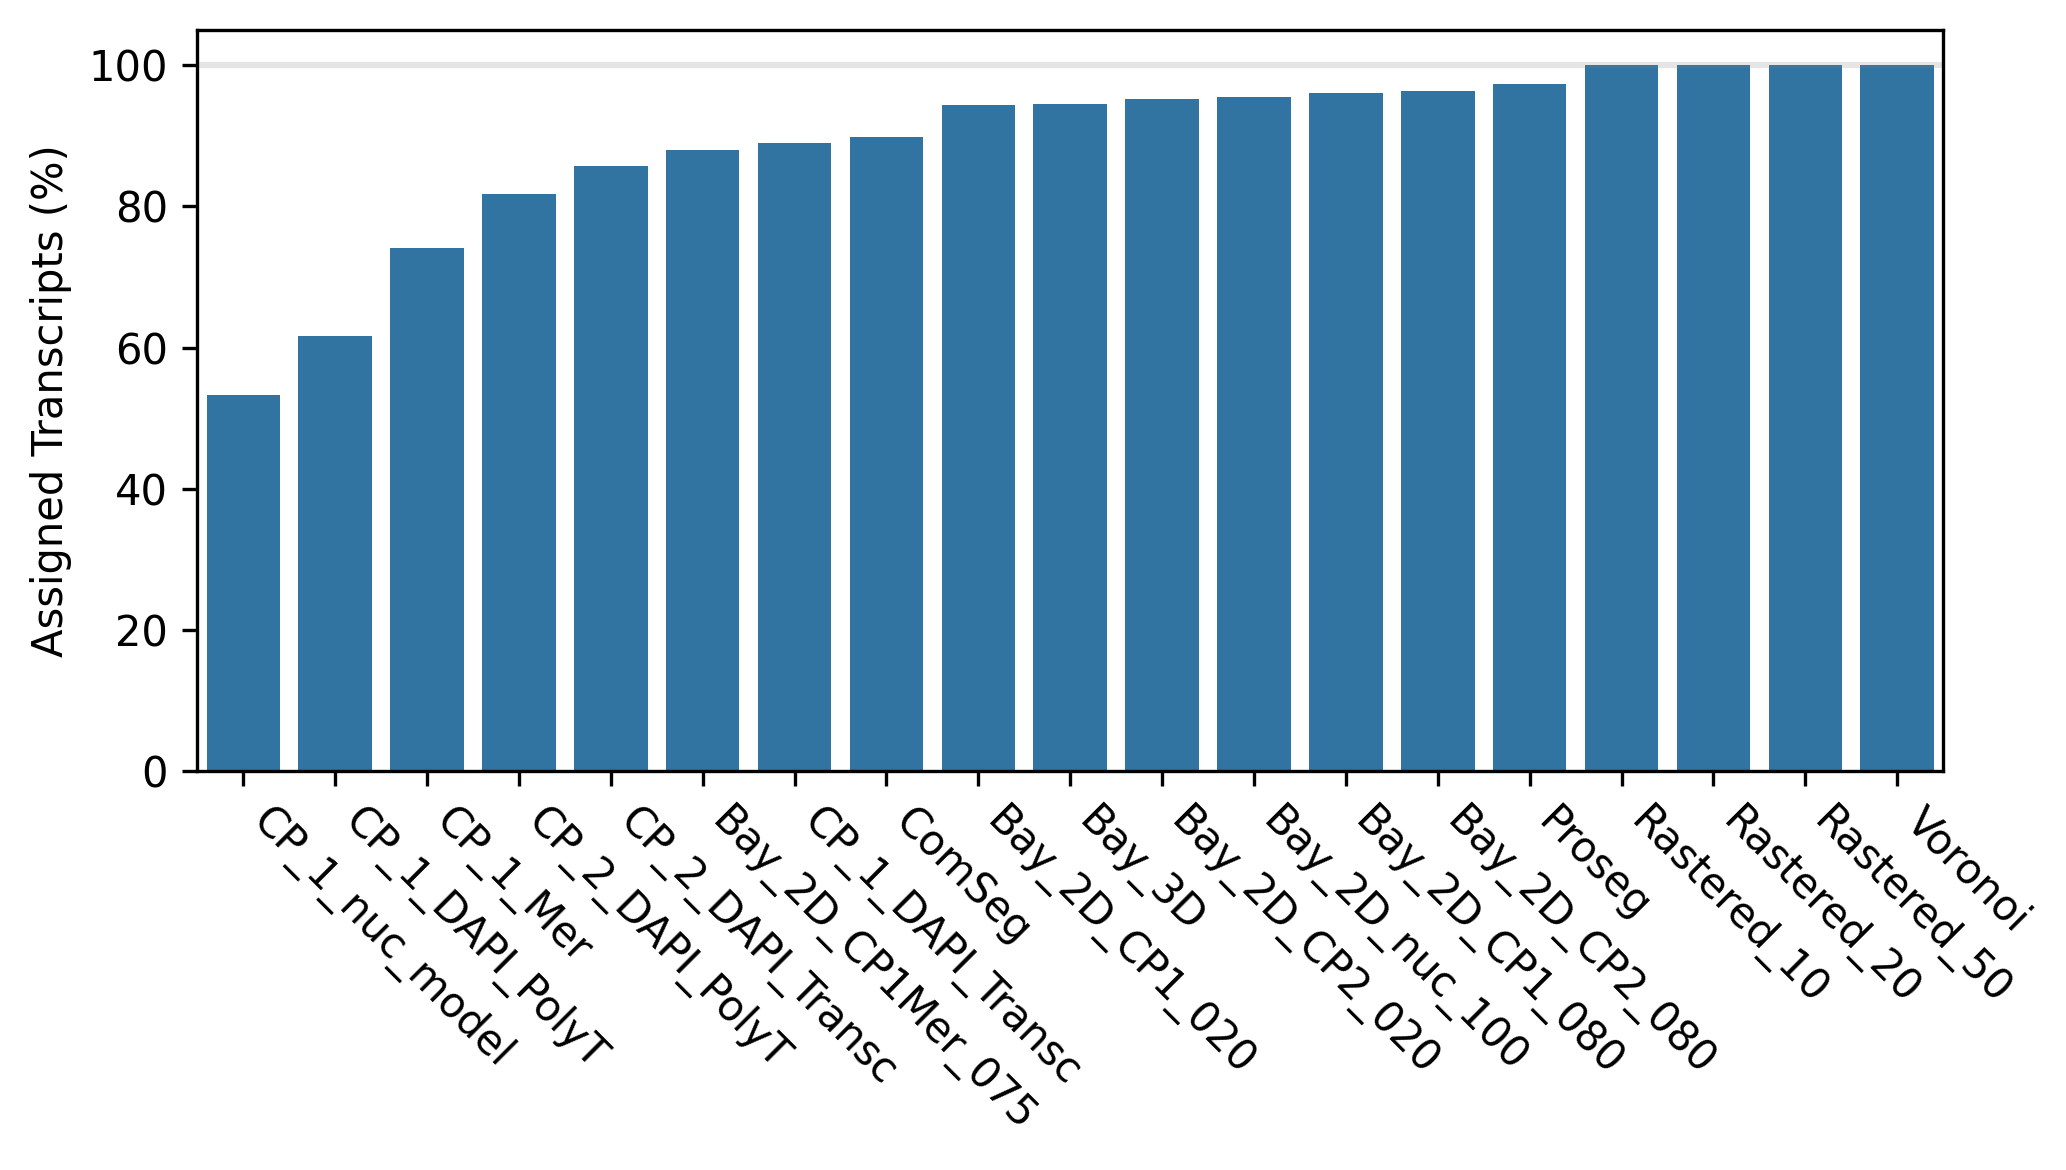

In [134]:
plot_data = ta.sort_values(by="pct_assigned")

plt.figure(figsize=(7, 4), dpi=300)
ax = sns.barplot(x="dataset", y="pct_assigned", data=plot_data)
ax.axhline(y=100, color="grey", linestyle="-", alpha=0.2)
plt.ylabel("Assigned Transcripts (%)")
plt.xlabel("")
plt.xticks(rotation=-45, ha="left")
plt.tight_layout()
plt.show()

# 2D + 3D

In [8]:
!conda install -n cellseg_benchmark -c conda-forge rtree -y

Channels:
 - conda-forge
Platform: linux-64
Solving environment: done


==> WARNING: A newer version of conda exists. <==
    current version: 24.11.3
    latest version: 25.5.1

Please update conda by running

    $ conda update -n base -c conda-forge conda



## Package Plan ##

  environment location: /home/ubuntu/miniforge3/envs/cellseg_benchmark

  added / updated specs:
    - rtree


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    libspatialindex-2.1.0      |       he57a185_0         390 KB  conda-forge
    rtree-1.4.0                |     pyh11ca60a_1          39 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         429 KB

The following NEW packages will be INSTALLED:

  libspatialindex    conda-forge/linux-64::libspatialindex-2.1.0-he57a185_0 
  rtree              conda-forge/noarch::rtree-1.4.0

In [11]:
# Logger setup
logger = logging.getLogger("compute_assigned_transcripts")
logger.setLevel(logging.INFO)
handler = logging.StreamHandler()
handler.setFormatter(logging.Formatter("%(asctime)s [%(levelname)s]: %(message)s"))
logger.addHandler(handler)

In [12]:
# CLI args
parser = argparse.ArgumentParser(
    description="Compute fraction of cell-assigned transcripts for all segmentation methods from a master-sdata."
)
parser.add_argument("sample", help="Sample, e.g., 'foxf2_s2_r1'")
# args = parser.parse_args()

# Simulate CLI args in Jupyter
args = parser.parse_args(["foxf2_s2_r1"])
print(args.sample)

foxf2_s2_r1


In [13]:
# Paths
base_path = Path("/dss/dssfs03/pn52re/pn52re-dss-0001/cellseg-benchmark")
sample_path = base_path / "samples" / args.sample
save_path = base_path / "samples" / args.sample / "misc"
save_path.mkdir(parents=True, exist_ok=True)

In [14]:
# Load sdata
logger.info("Loading sdata...")
sdata = read_zarr(sample_path / "sdata_z3.zarr")

2025-08-05 12:08:44,690 [INFO]: Loading sdata...
/home/ubuntu/miniforge3/envs/cellseg_benchmark/lib/python3.12/site-packages/zarr/creation.py:610: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
/home/ubuntu/miniforge3/envs/cellseg_benchmark/lib/python3.12/site-packages/zarr/creation.py:610: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
/home/ubuntu/miniforge3/envs/cellseg_benchmark/lib/python3.12/site-packages/zarr/creation.py:610: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
/home/ubuntu/miniforge3/envs/cellseg_benchmark/lib/python3.12/site-packages/zarr/creation.py:610: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
/home/ubuntu/miniforge3/envs/cellseg_benchmark/lib/python3.

In [ ]:
logger.info("Computing assigned transcripts...")
assigned_transcripts_results = count_assigned_transcripts(
    sdata, sdata_transcripts_key=next(iter(sdata.points.keys()))
)

2025-08-05 12:12:32,720 [INFO]: Computing assigned transcripts...


Loaded 66676355 transcripts
Processing Baysor_2D_Cellpose_1_DAPI_PolyT_0.2
  63428543/66676355 assigned (95.13%) - 2d
Processing Baysor_2D_Cellpose_1_DAPI_PolyT_0.8
  64424505/66676355 assigned (96.62%) - 2d
Processing Baysor_2D_Cellpose_1_DAPI_Transcripts_0.2
  63974928/66676355 assigned (95.95%) - 2d
Processing Baysor_2D_Cellpose_1_DAPI_Transcripts_0.8
  64525259/66676355 assigned (96.77%) - 2d
Processing Baysor_2D_Cellpose_1_nuclei_model_1.0
  64158244/66676355 assigned (96.22%) - 2d
Processing Baysor_2D_Cellpose_2_DAPI_PolyT_0.2
  63822923/66676355 assigned (95.72%) - 2d
Processing Baysor_2D_Cellpose_2_DAPI_PolyT_0.8
  64587204/66676355 assigned (96.87%) - 2d
Processing Baysor_2D_Cellpose_2_DAPI_Transcripts_0.2
  63969061/66676355 assigned (95.94%) - 2d
Processing Baysor_2D_Cellpose_2_DAPI_Transcripts_0.8


In [ ]:
# Flatten to df and save
df = pd.DataFrame.from_dict(assigned_transcripts_results, orient="index")
df.reset_index(inplace=True)
df = df.rename(columns={"index": "seg_method"})
logger.info("Saving results...")
df.to_csv(os.path.join(save_path, "assigned_transcripts_results.csv"), index=False)
logger.info("Done.")

In [ ]:
# dev:

In [ ]:
def count_assigned_transcripts(
    sdata, sdata_transcripts_key, boundaries_to_process=None
):
    """Calculate transcript assignment to cells across boundaries, handling 3D z-planes."""

    # Load transcripts
    transcripts_df = PointsModel.parse(
        sdata[sdata_transcripts_key], sort=True
    ).compute()[["x", "y", "gene", "transcript_id", "global_z"]]
    transcripts_gdf = gpd.GeoDataFrame(
        transcripts_df, geometry=gpd.points_from_xy(transcripts_df.x, transcripts_df.y)
    )
    print(f"Loaded {len(transcripts_gdf)} transcripts")

    # Filter boundaries
    available_boundaries = {
        k: v for k, v in sdata.shapes.items() if k.startswith("boundaries_")
    }
    if boundaries_to_process:
        boundary_keys = [
            name if name.startswith("boundaries_") else f"boundaries_{name}"
            for name in boundaries_to_process
        ]
        available_boundaries = {
            k: v for k, v in available_boundaries.items() if k in boundary_keys
        }

    results = {}

    def process_boundaries(boundaries_gdf, transcripts_subset):
        """Helper to process boundaries and return assigned count."""
        if boundaries_gdf.empty or transcripts_subset.empty:
            return 0, len(transcripts_subset)

        boundaries_unified = gpd.GeoDataFrame(
            geometry=[boundaries_gdf["geometry"].union_all(method="unary")]
        )
        joined = gpd.sjoin(
            transcripts_subset, boundaries_unified, how="left", predicate="within"
        )
        assigned = joined["index_right"].notna().sum()
        return assigned, len(transcripts_subset)

    for boundaries_name, boundaries in available_boundaries.items():
        dataset_name = boundaries_name.replace("boundaries_", "")
        print(f"Processing {dataset_name}")

        if (
            boundaries is None
            or boundaries.empty
            or "geometry" not in boundaries.columns
        ):
            print("  Skipping - invalid geometry")
            continue

        try:
            if "ZIndex" not in boundaries.columns:
                # 2D case
                assigned, total = process_boundaries(boundaries, transcripts_gdf)
                dimension = "2d"
            else:
                unique_z = boundaries["ZIndex"].unique()
                if len(unique_z) == 1:
                    # Single z-plane
                    z_boundaries = boundaries[boundaries["ZIndex"] == unique_z[0]]
                    z_transcripts = transcripts_gdf[
                        transcripts_gdf["global_z"] == unique_z[0]
                    ]
                    assigned, total = process_boundaries(z_boundaries, z_transcripts)
                    dimension = "2d"
                else:
                    # Multiple z-planes
                    print(f"  Processing {len(unique_z)} z-planes")
                    total_assigned, total_transcripts = 0, 0

                    for z_index in sorted(unique_z):
                        z_boundaries = boundaries[boundaries["ZIndex"] == z_index]
                        z_transcripts = transcripts_gdf[
                            transcripts_gdf["global_z"] == z_index
                        ]

                        z_assigned, z_total = process_boundaries(
                            z_boundaries, z_transcripts
                        )
                        total_assigned += z_assigned
                        total_transcripts += z_total

                    assigned, total = total_assigned, total_transcripts
                    dimension = "3d"

            results[dataset_name] = {
                "assigned_count": assigned,
                "unassigned_count": total - assigned,
                "total_count": total,
                "pct_assigned": round((assigned / total) * 100, 2) if total > 0 else 0,
                "dimension": dimension,
            }
            print(
                f"  {assigned}/{total} assigned ({results[dataset_name]['pct_assigned']}%) - {dimension}"
            )

        except Exception as e:
            print(f"  Error: {e}")

    return results

In [ ]:
next(iter(sdata.points.keys()))

In [70]:
boundaries_to_process = ["boundaries_vpt_2D_DAPI_PolyT"]
boundaries_to_process = ["boundaries_vpt_3D_DAPI_nuclei"]
# boundaries_to_process = ["boundaries_vpt_3D_DAPI_PolyT_nuclei"]
# boundaries_to_process = ["boundaries_vpt_2D_DAPI_PolyT_nuclei"]

In [71]:
%%time
assigned_transcripts_results = count_assigned_transcripts(
    sdata,
    sdata_transcripts_key=next(iter(sdata.points.keys())),
    # boundaries_to_process=boundaries_to_process,
)

Loaded 66676355 transcripts
Processing vpt_3D_DAPI_nuclei
  Processing 7 z-planes
  22369193/66676355 assigned (33.55%) - 3d
CPU times: user 8min 12s, sys: 17.5 s, total: 8min 29s
Wall time: 8min 15s


In [35]:
assigned_transcripts_results

{'Cellpose_1_nuclei_model': {'assigned_count': np.int64(0),
  'unassigned_count': np.int64(80528580),
  'total_count': 80528580,
  'pct_assigned': np.float64(0.0)}}

In [ ]:
# s4r1

In [37]:
# boundaries_vpt_3D_DAPI_nuclei
assigned_transcripts_results

{'vpt_3D_DAPI_nuclei': {'assigned_count': np.int64(26150852),
  'unassigned_count': np.int64(54377728),
  'total_count': 80528580,
  'pct_assigned': np.float64(32.47),
  'dimension': '3d'}}

In [40]:
# boundaries_vpt_3D_DAPI_PolyT
assigned_transcripts_results

{'vpt_3D_DAPI_PolyT': {'assigned_count': np.int64(20347385),
  'unassigned_count': np.int64(60181195),
  'total_count': 80528580,
  'pct_assigned': np.float64(25.27),
  'dimension': '3d'}}

In [43]:
# boundaries_vpt_3D_DAPI_PolyT_nuclei
assigned_transcripts_results

{'vpt_3D_DAPI_PolyT_nuclei': {'assigned_count': np.int64(30763406),
  'unassigned_count': np.int64(49765174),
  'total_count': 80528580,
  'pct_assigned': np.float64(38.2),
  'dimension': '3d'}}

In [65]:
# s2r1

In [66]:
# boundaries_vpt_3D_DAPI_PolyT_nuclei
assigned_transcripts_results

{'vpt_3D_DAPI_PolyT_nuclei': {'assigned_count': np.int64(26380072),
  'unassigned_count': np.int64(40296283),
  'total_count': 66676355,
  'pct_assigned': np.float64(39.56),
  'dimension': '3d'}}

In [69]:
# boundaries_vpt_2D_DAPI_PolyT_nuclei
assigned_transcripts_results

{'vpt_2D_DAPI_PolyT_nuclei': {'assigned_count': np.int64(8370793),
  'unassigned_count': np.int64(2873316),
  'total_count': 11244109,
  'pct_assigned': np.float64(74.45),
  'dimension': '2d'}}

In [72]:
# boundaries_vpt_3D_DAPI_nuclei
assigned_transcripts_results

{'vpt_3D_DAPI_nuclei': {'assigned_count': np.int64(22369193),
  'unassigned_count': np.int64(44307162),
  'total_count': 66676355,
  'pct_assigned': np.float64(33.55),
  'dimension': '3d'}}

In [75]:
# Flatten to DataFrame
df = pd.DataFrame.from_dict(assigned_transcripts_results, orient="index")
df.reset_index(inplace=True)
df = df.rename(columns={"index": "seg_method"})

In [76]:
df

,seg_method,assigned_count,unassigned_count,total_count,pct_assigned,dimension
0,vpt_3D_DAPI_nuclei,22369193,44307162,66676355,33.55,3d


In [83]:
output_path = os.path.join(
    data_dir, "samples", sample_name, "misc", "assigned_transcripts_results.csv"
)
os.makedirs(os.path.dirname(output_path), exist_ok=True)
df.to_csv(output_path, index=False)